In [1]:
import os

os.getcwd()

'/Users/yebhonelin/Documents/github/Practical-ML-by-WAI/8_final_proj/Team_YTK'

In [2]:
import tensorflow as tf

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2025-08-27 21:35:32.407165: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3


True

2025-08-27 21:35:32.407189: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-27 21:35:32.407192: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1756307132.407226  452251 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1756307132.407264  452251 pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
import os


DATA_DIR = os.getcwd() + '/VOC'
IMAGE_DIR = os.path.join(DATA_DIR, 'JPEGImages')
MASK_DIR = os.path.join(DATA_DIR, 'SegmentationClass_Encoded_JPG')

In [4]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
mask_paths = [os.path.join(MASK_DIR, fname) for fname in image_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


I0000 00:00:1756307132.418692  452251 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1756307132.418709  452251 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 358
Training examples: 286
Validation examples: 72


In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [7]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [8]:
BATCH_SIZE = 32
BUFFER_SIZE = 200 

In [9]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [10]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


--- Verifying a batch ---
Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 128, 128, 1)


2025-08-27 21:35:32.602974: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


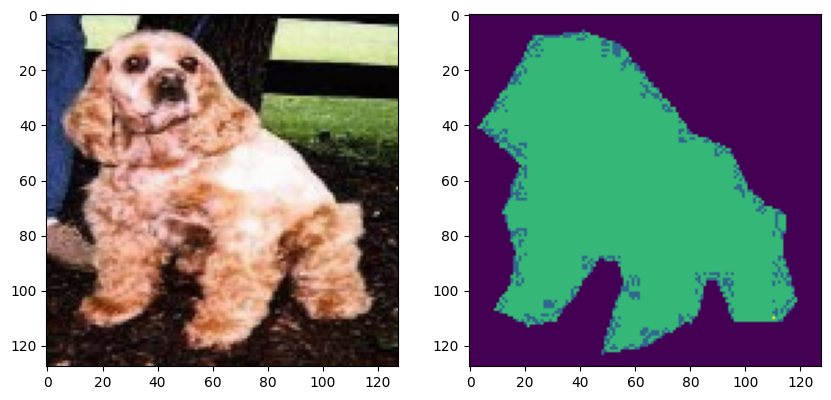

In [11]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0
    
    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()

    

In [12]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)
        
print(color_value_list) 

[0 1 2 3]
{np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3)}


## Build the U-Net Model


In [13]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    print(layer.name)

input_layer
conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
con

In [35]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers:
    print(layer.name)

input_layer_7
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_unet_with_resnet(input_shape, num_classes):
    """
    Builds a U-Net model using a pre-trained MobileNetV2 as the encoder.
    (Corrected Version)
    """

    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )


    layer_names = [
        "conv1_relu",          # 64x64
        "conv2_block3_out",    # 56x56
        "conv3_block4_out",    # 28x28
        "conv4_block6_out",    # 14x14
        "conv5_block3_out",    # 7x7 (bottleneck)
    ]
        
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model (the encoder)
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name="encoder")
    encoder.trainable = False


    #  Build the Decoder Path
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    print("#"*30)
    for temp in skips:
        print(temp)

    print("#"*30)
    
    
    x = skips[-1]
    
    decoder_skips = list(reversed(skips[:-1]))

    
    
    print("#"*30)
    for temp in decoder_skips:
        print(temp)
    print("#"*30)
    
    print(x)
    print("#"*30)

    for i, skip in enumerate(decoder_skips):
        x = layers.Conv2DTranspose(filters=512 // (2**i), kernel_size=2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
    
    # It takes the 64x64 feature map and upsamples it to 128x128.
    outputs = layers.Conv2DTranspose(
        filters=num_classes,
        kernel_size=2,
        strides=2,
        padding='same',
        activation='softmax'  # Apply softmax directly here
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [42]:
NUM_CLASSES = 3
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_with_resnet(input_shape, NUM_CLASSES)
model.summary()

##############################
<KerasTensor shape=(None, 64, 64, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1353>
<KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1354>
<KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1355>
<KerasTensor shape=(None, 8, 8, 1024), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1356>
<KerasTensor shape=(None, 4, 4, 2048), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1357>
##############################
##############################
<KerasTensor shape=(None, 8, 8, 1024), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1356>
<KerasTensor shape=(None, 16, 16, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1355>
<KerasTensor shape=(None, 32, 32, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1354>
<KerasTensor shape=(None, 64, 64, 64), dtype=float32, s

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 64, 64,   │ 23,587,712 │ input_layer_11[0… │
│ (Functional)        │ 64), (None, 32,   │            │                   │
│                     │ 32, 256), (None,  │            │                   │
│                     │ 16, 16, 512),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 1024), (None, 4,  │            │                   │
│                     │ 4, 2048)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 8, 8, 512) │  4,194,816 │ encoder[0][4]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1536)             │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 512) │  7,078,400 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 16, 16,    │    524,544 │ conv2d_15[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 768)              │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │  1,769,728 │ concatenate_8[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_16[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 32, 32,    │    131,200 │ conv2d_17[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 384)              │            │ encoder[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │    442,496 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_18[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 64, 64,    │     32,832 │ conv2d_19[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 40,970,691 (156.29 MB)

 Trainable params: 17,382,979 (66.31 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [43]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

8


In [50]:
from tensorflow.keras.utils import plot_model

# pip install pydot
# Save model architecture as image
plot_model(model, to_file="tf_lr_model_architecture.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [71]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)

checkpoint_path = os.getcwd() + "/model_keras.{epoch:04d}.weights.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=20)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler,cp_callback]
)

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.6682 - loss: 0.7440 - val_accuracy: 0.6698 - val_loss: 0.7468 - learning_rate: 1.0000e-06
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.6733 - loss: 0.7407 - val_accuracy: 0.6832 - val_loss: 0.7232 - learning_rate: 1.0000e-06
Epoch 3/40
3/8 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.6898 - loss: 0.7169
Epoch 3: saving model to /Users/yebhonelin/Documents/github/Practical-ML-by-WAI/8_final_proj/Team_YTK/model_keras.0003.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.6795 - loss: 0.7280 - val_accuracy: 0.6607 - val_loss: 0.7725 - learning_rate: 1.0000e-06
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.6758 - loss: 0.7411 - val_accuracy: 0.6752 - val_loss: 0.7440 - learning_rate: 1.0000e-06
Epoch 5/40
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6819 - loss: 0.7269
Epoch 5: saving model to /Users/yebhonelin/Documents/github/Practical-ML-by-WAI/8_final_proj/Team

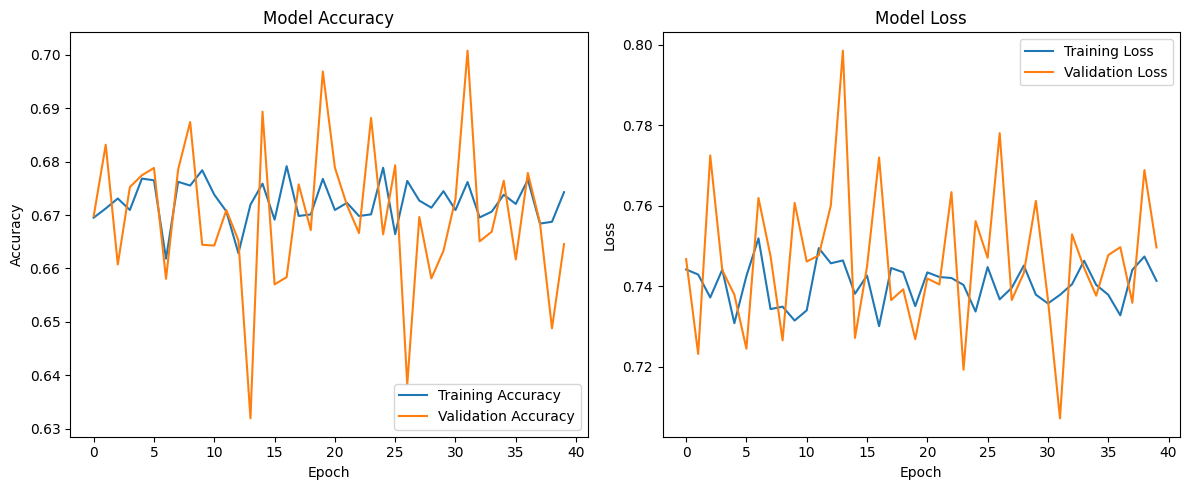

In [72]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [73]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6559 - loss: 0.7694

Test Loss: 0.7610
Test Accuracy: 0.6605


### Model Saving and Prediction

In [76]:
model.save("model_resnet.keras")

In [77]:
load_model = tf.keras.models.load_model("/Users/yebhonelin/Documents/github/Practical-ML-by-WAI/8_final_proj/Team_YTK/resnet_model/model_resnet.keras")

In [78]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [79]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0
    

    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img
    

In [80]:
def predict_and_visualize(image_path, model):

   
    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)
    
    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


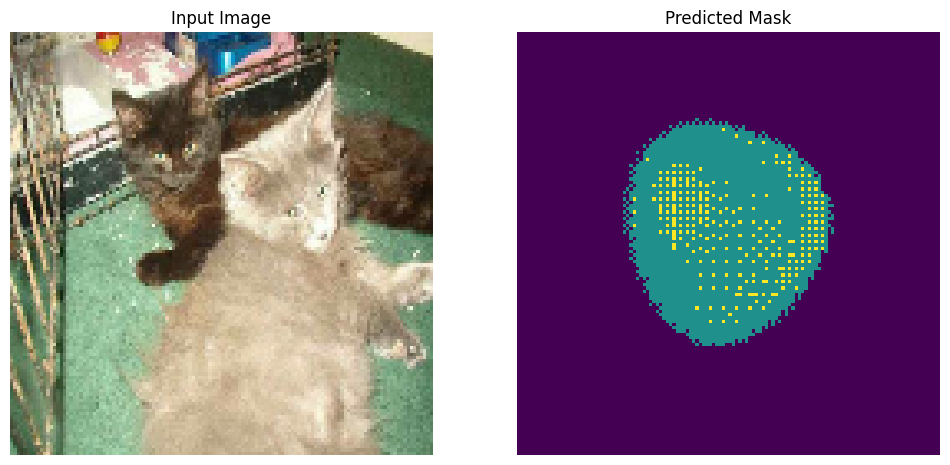

In [84]:
test_path = "/Users/yebhonelin/Documents/github/Practical-ML-by-WAI/8_final_proj/Team_YTK/test_dataset/cats_and_dogs_filtered/test/cats/cat.2367.jpg"
#test_path = "dataset/car-segmentation/images/003.png"

predict_and_visualize(test_path, load_model)

In [85]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)

    
    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]
    
    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))
    
    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]
        
        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")
        
        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis') 
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


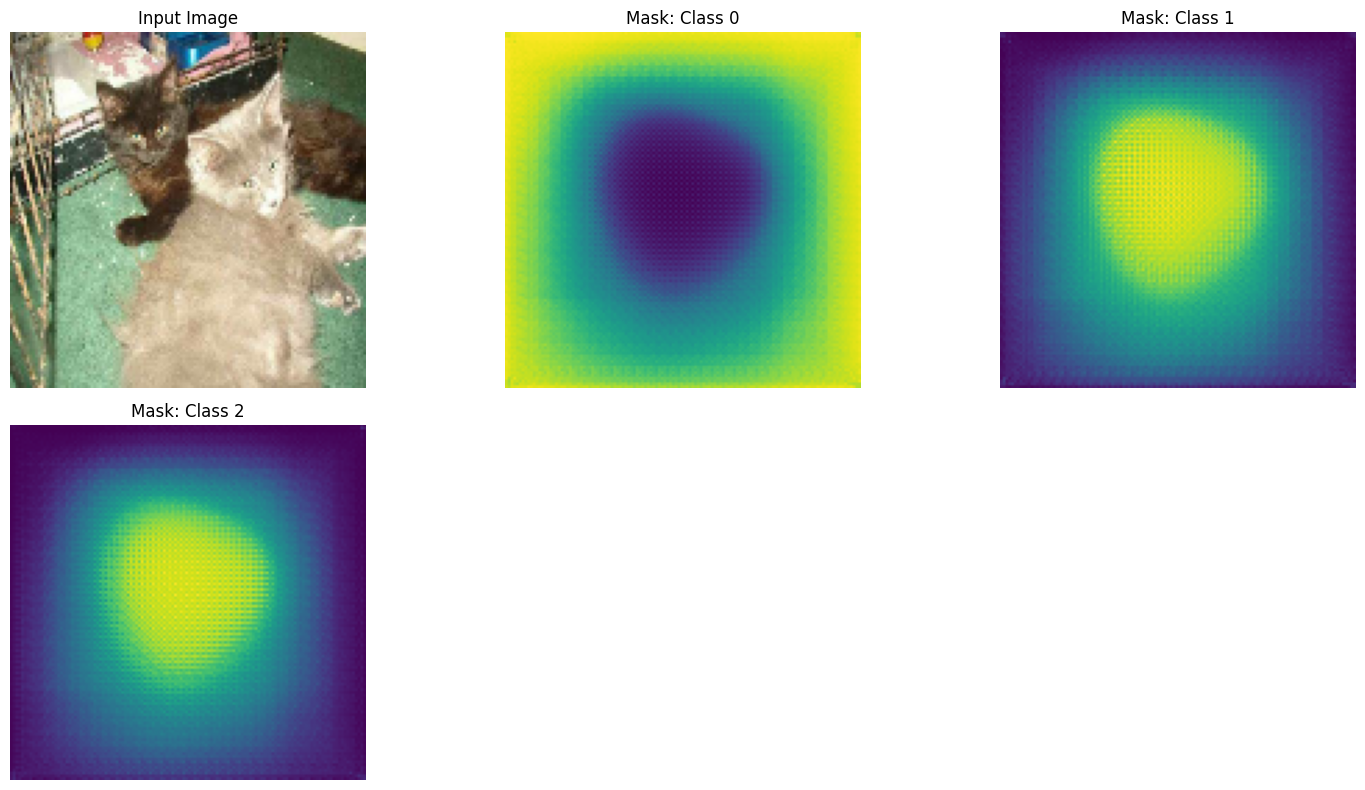

In [86]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, load_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


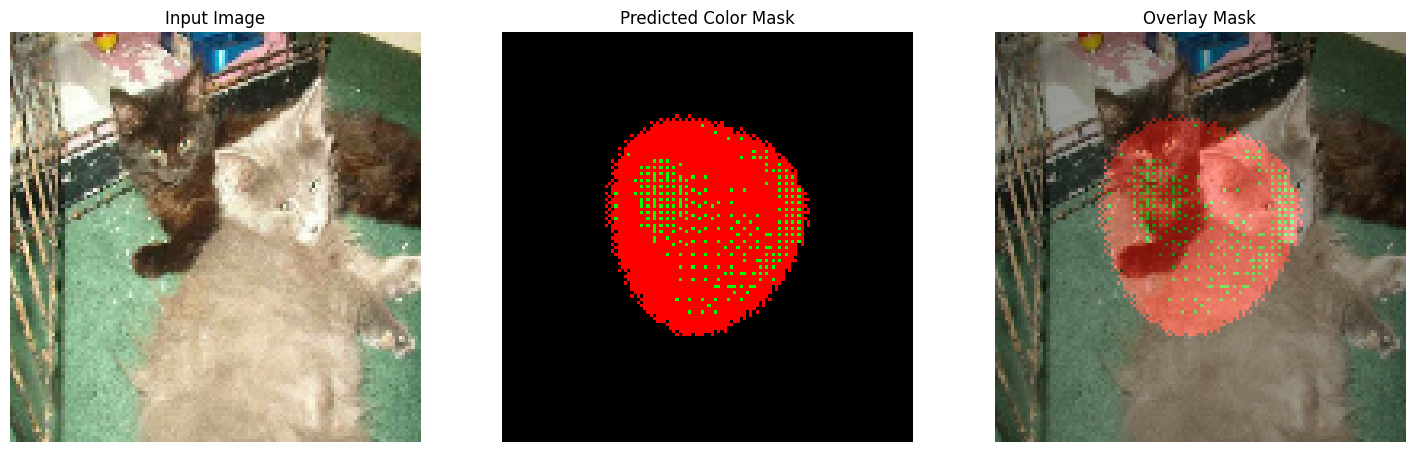

In [87]:
import numpy as np
import cv2 

# 1. Define a color for each of your 5 classes (0 to 4)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (e.g., background)
    [255, 0, 0],     # Class 1: Red
    [0, 255, 0],     # Class 2: Green
    [0, 0, 255],     # Class 3: Blue
    [255, 255, 0]    # Class 4: Yellow
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()
    
    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)
    
    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)
    
    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)
    
    # Display the results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()


test_path = "/Users/yebhonelin/Documents/github/Practical-ML-by-WAI/8_final_proj/Team_YTK/test_dataset/cats_and_dogs_filtered/test/cats/cat.2367.jpg"
predict_and_visualize_color(test_path, load_model, COLOR_MAP)